## Data

The data for this assignment will be the MovieLens dataset
MovieLens

Use the MovieLens 25 M dataset

## Tasks

1. Using Spark, design and implement a Recommender System to predict ratings of movies. Base your utility matrix on the Movie Lens 25M dataset. Use the Products of Factors technique for your system and optimize the loss function with ALS.

2. To tune your solution, use crossvalidation over a subset (80%) of the data. You can use the utilities in Spark to generate the folds. Use the rest of the dataset (20%) to test the system after tuning.Compute RMSE, MSE, and MAP.

3. Implement a hybrid system that uses the ALS solution and item-item CF. You can use as guidance the scripts Hybrid Alg. and Hybrid Testing changing statements where appropriate. How does the oerformance change?

4. Implement a third component, treating the problem as one of supervised learming prediction (i.e., given the features of the movie -found in Movies Data File Structure- and user, predict the rating this user would give to this movie). Choose a predictive model in MLLIB for this task. Incorporate the new model into the hybrid system you built before and test the performance of this new hybrid. Tune the weight you give to each model. How does the performance change?

In [1]:
'''
Team Members:

1. Kumar Shubham
2. Deep Vora

'''

'\nTeam Members: \n\n1. Kumar Shubham\n2. Deep Vora\n\n'

EDA

In [1]:
!pip install pyspark --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.9/316.9 MB 1.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [2]:
import random
import pandas as pd
import matplotlib.pyplot as plt
from pyspark.ml.evaluation import RankingEvaluator
from pyspark.mllib.evaluation import RankingMetrics
import seaborn as sns
from pyspark.ml.recommendation import ALS
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.linalg import Vectors, SparseVector
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.window import Window
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.feature import Normalizer
import networkx as nx
import pyspark.sql.types as T
import numpy as np
from pyspark.ml.regression import LinearRegression
from pyspark.ml import Pipeline
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

In [3]:
from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession

conf = SparkConf()
# conf.set("spark.executor.memory","8g")
# conf.set("spark.executor.cores", "4")
# conf.set("spark.driver.memory", "8g")
# conf.set("spark.driver.cores", "2")
sc = SparkContext.getOrCreate(conf)
spark = SparkSession.builder.appName("MovieRecommender").getOrCreate()

In [4]:
ratings_df = spark.read.csv("/content/drive/MyDrive/CS657/ml-25m/ratings.csv", header=True, inferSchema=True)

In [5]:
movies_df = spark.read.csv("/content/drive/MyDrive/CS657/ml-25m/movies.csv", header=True, inferSchema=True)

In [93]:
movies_df.count()

62423

In [ ]:
ratings_df.count()

25000095

In [ ]:
ratings_df.show()

+------+-------+------+----------+
|userId|movieId|rating| timestamp|
+------+-------+------+----------+
|     1|    296|   5.0|1147880044|
|     1|    306|   3.5|1147868817|
|     1|    307|   5.0|1147868828|
|     1|    665|   5.0|1147878820|
|     1|    899|   3.5|1147868510|
|     1|   1088|   4.0|1147868495|
|     1|   1175|   3.5|1147868826|
|     1|   1217|   3.5|1147878326|
|     1|   1237|   5.0|1147868839|
|     1|   1250|   4.0|1147868414|
|     1|   1260|   3.5|1147877857|
|     1|   1653|   4.0|1147868097|
|     1|   2011|   2.5|1147868079|
|     1|   2012|   2.5|1147868068|
|     1|   2068|   2.5|1147869044|
|     1|   2161|   3.5|1147868609|
|     1|   2351|   4.5|1147877957|
|     1|   2573|   4.0|1147878923|
|     1|   2632|   5.0|1147878248|
|     1|   2692|   5.0|1147869100|
+------+-------+------+----------+
only showing top 20 rows



In [6]:
# ratings_df_t = ratings_df.limit(100000)

In [12]:
movies = movies_df.toPandas()
ratings = ratings_df_t.toPandas()
user_item_matrix = ratings.pivot("userId", "movieId", "rating")

<ipython-input-12-939f049fa698>:3: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  user_item_matrix = ratings.pivot("userId", "movieId", "rating")


In [13]:
user_item_matrix

movieId,1,2,3,4,5,6,7,8,9,10,...,204692,204698,204704,205054,205072,205106,205413,205499,205557,206272
userId,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
753,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
754,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
755,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<ipython-input-14-f6ef4c0376da>:9: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  user_item_matrix = sampled_ratings_df.pivot("userId", "movieId", "rating")


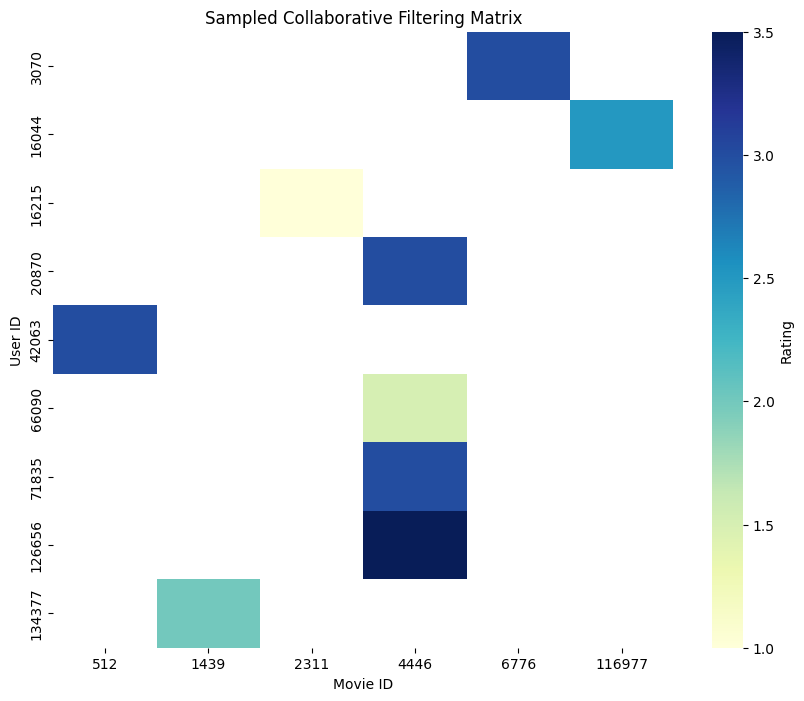

In [14]:
sampled_users = [row["userId"] for row in random.sample(ratings_df.select("userId").distinct().collect(), 100)]
sampled_items = [row["movieId"] for row in random.sample(ratings_df.select("movieId").distinct().collect(), 100)]

# Filter the DataFrame based on sampled users and items
sampled_ratings_df = ratings_df.filter(F.col("userId").isin(sampled_users)).filter(F.col("movieId").isin(sampled_items))

sampled_ratings_df = sampled_ratings_df.toPandas()
# Pivot the DataFrame to create a user-item matrix
user_item_matrix = sampled_ratings_df.pivot("userId", "movieId", "rating")

# Create a heatmap using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(user_item_matrix, cmap="YlGnBu", cbar_kws={'label': 'Rating'})
plt.title("Sampled Collaborative Filtering Matrix")
plt.xlabel("Movie ID")
plt.ylabel("User ID")
plt.show()

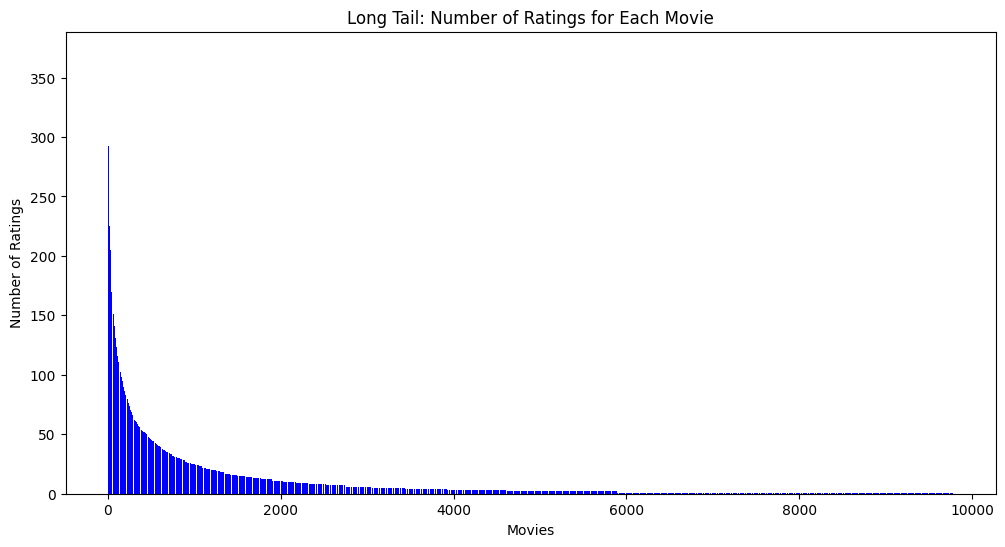

In [15]:
# Merge movies and ratings
movie_ratings = pd.merge(ratings, movies, on='movieId')

# Calculate the number of ratings for each movie
ratings_count = movie_ratings.groupby('title').size().sort_values(ascending=False)

# Plot the long tail
plt.figure(figsize=(12, 6))
plt.bar(range(len(ratings_count)), ratings_count, color='blue')
plt.xlabel('Movies')
plt.ylabel('Number of Ratings')
plt.title('Long Tail: Number of Ratings for Each Movie')
plt.show()

In [11]:
# Split the data into training and testing sets
(training, test) = ratings_df.randomSplit([0.8, 0.2], seed=7856)

In [7]:
# (train_t, test_t) = ratings_df_t.randomSplit([0.8, 0.2], seed=7856)

ALS Algorithm

In [21]:
# Create an ALS model
als = ALS(userCol="userId", itemCol="movieId", ratingCol="rating", coldStartStrategy="drop")

# Set the hyperparameters for ALS
als.setUserCol("userId")
als.setItemCol("movieId")
als.setRatingCol("rating")

# Fit the model to the training data
als_model = als.fit(training)

In [22]:
# Make predictions on the test set
als_pred = als_model.transform(test)

In [23]:
als_pred = als_pred.withColumn("prediction", F.round(F.col("prediction"),1))

In [11]:
# Evaluate the model using RMSE (Root Mean Squared Error)
als_evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating", predictionCol="prediction")
als_rmse = als_evaluator.evaluate(als_pred)
print("Root Mean Squared Error (RMSE) = " + str(als_rmse))

Root Mean Squared Error (RMSE) = 0.8017801618368304


In [12]:
# Evaluate the model using RMSE (Root Mean Squared Error)
als_evaluator2 = RegressionEvaluator(metricName="mse", labelCol="rating", predictionCol="prediction")
als_mse = als_evaluator2.evaluate(als_pred)
print("Mean Squared Error (MSE) = " + str(als_mse))

Mean Squared Error (MSE) = 0.642851427915094


In [14]:
# Generate top 10 movie recommendations for each user
userRecs = als_model.recommendForAllUsers(10)

In [19]:
movie_names = userRecs.select("userId", "recommendations.movieId") \
    .withColumn("movieId", F.explode("movieId")) \
    .join(movies_df, on="movieId", how="left")

In [20]:
movie_names.columns

['movieId', 'userId', 'title', 'genres']

In [21]:
movie_names = movie_names.groupBy("userId").agg(F.collect_list(F.struct("title")).alias("recommendations"))

In [22]:
display(movie_names.show(truncate=False))

+------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|userId|recommendations                                                                                                                                                                                                                                                                                                                                                 |
+------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

None

Fine Tuning ALS - Using Cross Validation

In [8]:
# Cross-Validation
def calculate_map_at_k(predictions, k):
    user_rankings = predictions.groupBy("userId").agg(F.collect_list("movieId").alias("rankedMovies"))
    user_true_rankings = predictions.where("rating >= 4.0").groupBy("userId").agg(F.collect_list("movieId").alias("trueMovies"))
    user_predictions = user_rankings.join(user_true_rankings, "userId").rdd.map(lambda row: (row[1], row[2]))
    ranking_metrics = RankingMetrics(user_predictions)
    map_at_k = ranking_metrics.meanAveragePrecision
    return map_at_k

In [9]:
als = ALS(userCol="userId", itemCol="movieId", ratingCol="rating", coldStartStrategy="drop", implicitPrefs=False)
param_grid = ParamGridBuilder().addGrid(als.rank, [5, 10, 20]).addGrid(als.regParam, [0.05, 0.1, 0.2]).build()
evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating", predictionCol="prediction")
cv = CrossValidator(estimator=als, estimatorParamMaps=param_grid, evaluator=evaluator, numFolds=5)
cv_model = cv.fit(training)
best_model = cv_model.bestModel
cv_predictions = best_model.transform(test)
cv_rmse = evaluator.evaluate(cv_predictions)
cv_mse = evaluator.evaluate(cv_predictions, {evaluator.metricName: "mse"})
cv_map_at_k = calculate_map_at_k(cv_predictions, k=10)
print(f"RMSE: {cv_rmse}, MSE: {cv_mse}, MAP at K: {cv_map_at_k}")

/usr/local/lib/python3.10/dist-packages/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


RMSE: 0.8940665670156733, MSE: 0.7993550262551915, MAP at K: 0.6825662149178818


In [10]:
best_rank = best_model.rank
best_reg_param = best_model._java_obj.parent().getRegParam()
print(f"Best Rank: {best_rank}, Best Regularization Parameter: {best_reg_param}")

Best Rank: 10, Best Regularization Parameter: 0.2


Implement a hybrid system that uses the ALS solution and item-item CF.
You can use as guidance the scripts Hybrid Alg. and Hybrid Testing changing statements where appropriate. How does the performance change?

ITEM ITEM CF

In [16]:
moviePairs = ratings_df.alias('df1').join(ratings_df.alias('df2'),
                       ((F.col('df1.userId') == F.col('df2.userId')) & (F.col('df1.movieId') < F.col('df2.movieId'))))\
                       .select(F.col('df1.movieId').alias('movieId1'), F.col('df2.movieId').alias('movieId2'), F.col('df1.rating').alias('rating1'), F.col('df2.rating').alias('rating2'))

In [17]:
def computeCosineSimilarity(df):
    # Create the new columns xx, yy, and xy for cosine similarity computation
    df_score = df.withColumn('xx', F.col('rating1') * F.col('rating1')) \
                 .withColumn('yy', F.col('rating2') * F.col('rating2')) \
                 .withColumn('xy', F.col('rating1') * F.col('rating2'))

    # Aggregate the results by unique movie pairs and calculate numerator, denominator, and number of shared viewers (i.e. numPairs)
    df_score = df_score.groupby(['movieId1', 'movieId2']) \
                        .agg(F.sum(F.col('xy')).alias('numerator'),
                            (F.sqrt(F.sum(F.col('xx'))) * F.sqrt(F.sum(F.col('yy')))).alias('denominator'),
                            F.count(F.col('xy')).alias('num_pairs'))

    df_score = df_score.withColumn('cosine_score', F.when(F.col('denominator') != 0, F.col('numerator')/F.col('denominator')).otherwise(F.lit(0))) \
              .select(['movieId1', 'movieId2', 'cosine_score', 'num_pairs'])

    return df_score


In [18]:
similar_movie_pairs_df = computeCosineSimilarity(moviePairs)

In [111]:
data = similar_movie_pairs_df.select('movieId1', 'movieId2', 'cosine_score').limit(10)

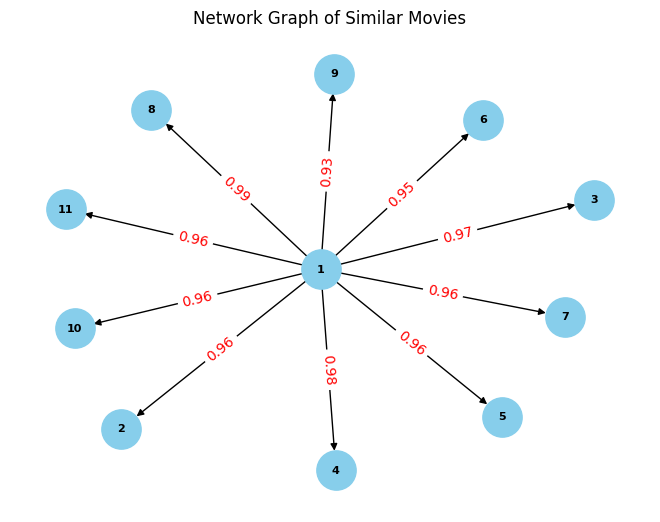

In [112]:
G = nx.DiGraph()

# Add nodes and edges with similarity scores
for movieId1, movieId2, cosine_score in data.collect():
    G.add_edge(movieId1, movieId2, weight=cosine_score)

# Plot the network graph
pos = nx.spring_layout(G)  # You can choose different layout algorithms
edge_labels = {(movieId1, movieId2): f"{cosine_score:.2f}" for movieId1, movieId2, cosine_score in data.collect()}

nx.draw(G, pos, with_labels=True, font_size=8, node_size=800, node_color="skyblue", font_color="black", font_weight="bold", arrowsize=10)
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color="red")

plt.title("Network Graph of Similar Movies")
plt.show()

In [19]:
# Split the data into training and testing sets
(item_item_train, item_item_test) = similar_movie_pairs_df.randomSplit([0.8, 0.2], seed=7856)

In [24]:
# Combine ALS and item-item predictions
combined_predictions = (
    als_pred.join(item_item_test, als_pred["movieId"] == item_item_test["movieId1"], how="inner")
    .select(
        als_pred["userId"],
        als_pred["movieId"],
        als_pred["prediction"].alias("als_prediction"),
        als_pred["rating"],
        item_item_test["movieId2"],
        item_item_test["cosine_score"]
    )
    .where("cosine_score > 0.97 AND num_pairs > 50")
)

In [25]:
combined_predictions2=combined_predictions.withColumn("weighted_prediction", (F.col("als_prediction") * 0.8) + (F.col("cosine_score") * 0.8)) \
        .groupBy("userId", "movieId") \
        .agg(F.max("weighted_prediction").alias("weighted_prediction"),F.max("rating").alias("rating"))

In [26]:
combined_predictions2=combined_predictions2.withColumn("weighted_prediction",F.round(F.col("weighted_prediction"),1))

In [27]:
top10movies = combined_predictions.join(movies_df, combined_predictions.movieId==movies_df.movieId,how="left") \
              .select(combined_predictions["userId"],combined_predictions["movieId2"],movies_df["title"],combined_predictions["cosine_score"])

In [ ]:
top10movies=top10movies \
        .groupBy("userId","title") \
        .agg(F.max("cosine_score"),F.max("rating").alias("rating"))

In [28]:
from pyspark.sql.window import Window
window_spec = Window.partitionBy("userId").orderBy(F.desc("cosine_score"))
ranked_recommendations = top10movies.withColumn("rank", F.row_number().over(window_spec))
top_10_recommendations = ranked_recommendations.filter("rank <= 10")
aggregated_recommendations = top_10_recommendations.groupBy("userId").agg(F.collect_list(F.struct("title", "cosine_score")).alias("recommendations"))
aggregated_recommendations.show(truncate=False)

+------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|userId|recommendations                                                                                                                                                                                                

In [59]:
#wts: 0.8, 0.9

In [60]:
# hybrid_eval1 = RegressionEvaluator(metricName="rmse", labelCol="rating", predictionCol="weighted_prediction")
# hybrid_eval1_rmse = hybrid_eval1.evaluate(combined_predictions2)
# print("Root Mean Squared Error (RMSE) = " + str(hybrid_eval1_rmse))

Root Mean Squared Error (RMSE) = 0.8504000445661729


In [61]:
# hybrid_eval2 = RegressionEvaluator(metricName="mse", labelCol="rating", predictionCol="weighted_prediction")
# hybrid_eval1_mse = hybrid_eval2.evaluate(combined_predictions2)
# print("Mean Squared Error (MSE) = " + str(hybrid_eval1_mse))

Mean Squared Error (MSE) = 0.7231802357981488


In [ ]:
#wts - 0.8, 0.8

In [45]:
hybrid_eval1 = RegressionEvaluator(metricName="rmse", labelCol="rating", predictionCol="weighted_prediction")
hybrid_eval1_rmse = hybrid_eval1.evaluate(combined_predictions2)
print("Root Mean Squared Error (RMSE) = " + str(hybrid_eval1_rmse))

Root Mean Squared Error (RMSE) = 0.7794850872648431


In [46]:
hybrid_eval2 = RegressionEvaluator(metricName="mse", labelCol="rating", predictionCol="weighted_prediction")
hybrid_eval1_mse = hybrid_eval2.evaluate(combined_predictions2)
print("Mean Squared Error (MSE) = " + str(hybrid_eval1_mse))

Mean Squared Error (MSE) = 0.6075970012682801


In [ ]:
#wts - 0.7, 0.8

In [49]:
# hybrid_eval1 = RegressionEvaluator(metricName="rmse", labelCol="rating", predictionCol="weighted_prediction")
# hybrid_eval1_rmse = hybrid_eval1.evaluate(combined_predictions2)
# print("Root Mean Squared Error (RMSE) = " + str(hybrid_eval1_rmse))

Root Mean Squared Error (RMSE) = 0.9203506418896282


In [50]:
# hybrid_eval2 = RegressionEvaluator(metricName="mse", labelCol="rating", predictionCol="weighted_prediction")
# hybrid_eval1_mse = hybrid_eval2.evaluate(combined_predictions2)
# print("Mean Squared Error (MSE) = " + str(hybrid_eval1_mse))

Mean Squared Error (MSE) = 0.8470453040266508


In [ ]:
#wts - 0.5, 0.5

In [55]:
# hybrid_eval1 = RegressionEvaluator(metricName="rmse", labelCol="rating", predictionCol="weighted_prediction")
# hybrid_eval1_rmse = hybrid_eval1.evaluate(combined_predictions2)
# print("Root Mean Squared Error (RMSE) = " + str(hybrid_eval1_rmse))

Root Mean Squared Error (RMSE) = 1.753861785827721


In [56]:
# hybrid_eval2 = RegressionEvaluator(metricName="mse", labelCol="rating", predictionCol="weighted_prediction")
# hybrid_eval1_mse = hybrid_eval2.evaluate(combined_predictions2)
# print("Mean Squared Error (MSE) = " + str(hybrid_eval1_mse))

Mean Squared Error (MSE) = 3.0760311637868027


In [ ]:
als_rmse = als_rmse
als_mse = als_mse

cv_rmse = cv_rmse
cv_mse = cv_mse

hybrid_rmse = hybrid_eval1_rmse
hybrid_mse =  hybrid_eval1_mse

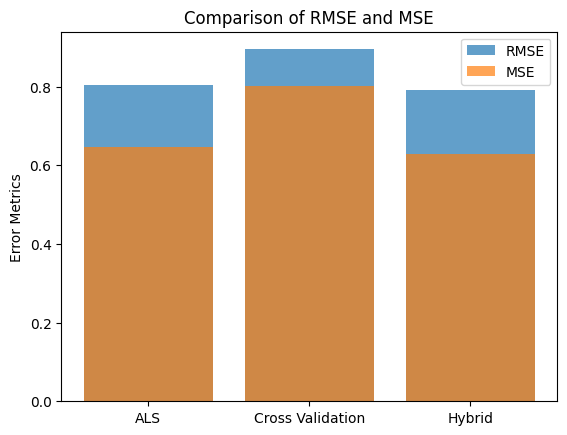

In [86]:
# Plotting
labels = ['ALS', 'Cross Validation', 'Hybrid']
rmse_values = [als_rmse, cv_rmse, hybrid_rmse]
mse_values = [als_mse, cv_mse, hybrid_mse]

fig, ax = plt.subplots()

# Plot RMSE
ax.bar(labels, rmse_values, label='RMSE', alpha=0.7)

# Plot MSE
ax.bar(labels, mse_values, label='MSE', alpha=0.7)

ax.set_ylabel('Error Metrics')
ax.set_title('Comparison of RMSE and MSE')
ax.legend()

plt.show()

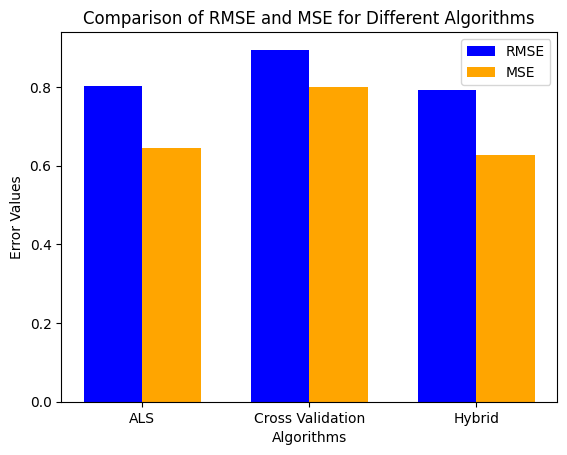

In [90]:
algorithms = ['ALS', 'Cross Validation', 'Hybrid']
rmse_values = [als_rmse, cv_rmse, hybrid_rmse]
mse_values = [als_mse, cv_mse, hybrid_mse]

bar_width = 0.35
index = np.arange(len(algorithms))

plt.bar(index, rmse_values, bar_width, label='RMSE', color='blue')
plt.bar(index + bar_width, mse_values, bar_width, label='MSE', color='orange')

plt.xlabel('Algorithms')
plt.ylabel('Error Values')
plt.title('Comparison of RMSE and MSE for Different Algorithms')
plt.xticks(index + bar_width / 2, algorithms)
plt.legend()
plt.show()


New Hybrid Score

In [113]:
assembler = VectorAssembler(inputCols=["userId", "movieId"], outputCol="features")
assembled_df = assembler.transform(ratings_df.drop('timestamp'))

In [114]:
train_df, test_df = assembled_df.randomSplit([0.8, 0.2], seed=42)

In [116]:
lr = LinearRegression(featuresCol="features", labelCol="rating")
lr_model = lr.fit(train_df)

In [117]:
lr_predictions = lr_model.transform(test_df)

In [119]:
lr_predictions=lr_predictions.withColumn("prediction",F.round(F.col("prediction"), 1))

In [120]:
lr_evaluator = RegressionEvaluator(labelCol='rating', predictionCol='prediction', metricName='rmse')
lr_rmse = lr_evaluator.evaluate(lr_predictions)
print(f"Root Mean Squared Error (RMSE): {lr_rmse}")

Root Mean Squared Error (RMSE): 1.061577491645831


In [121]:
lr_evaluator2 = RegressionEvaluator(labelCol='rating', predictionCol='prediction', metricName='mse')
lr_mse = lr_evaluator2.evaluate(lr_predictions)
print(f"Mean Squared Error (MSE): {lr_mse}")

Mean Squared Error (MSE): 1.1269467707690544


In [127]:
# Combine previous Hybrid model with the linear regression
combined_predictions3 = (
    combined_predictions.join(lr_predictions, (combined_predictions["userId"] == lr_predictions["userId"]) & (combined_predictions["movieId"] == lr_predictions["movieId"]), how="inner")
    .select(
        combined_predictions["userId"],
        combined_predictions["movieId"],
        combined_predictions["als_prediction"],
        combined_predictions["rating"],
        combined_predictions["movieId2"],
        combined_predictions["cosine_score"],
        lr_predictions["prediction"]
    )
)

In [147]:
combined_predictions4=combined_predictions3.withColumn("weighted_prediction", (F.col("als_prediction") * 0.8) + (F.col("cosine_score") * 0.4) + (F.col("prediction") * 0.2)) \
        .groupBy("userId", "movieId") \
        .agg(F.max("weighted_prediction").alias("weighted_prediction"),F.max("rating").alias("rating"))

In [148]:
combined_predictions4=combined_predictions4.withColumn("weighted_prediction",F.round(F.col("weighted_prediction"),1))

In [149]:
#WTS - 0.5, 0.5, 0.2

In [150]:
# hybrid_eval3 = RegressionEvaluator(labelCol='rating', predictionCol='weighted_prediction', metricName='rmse')
# hybrid_eval3_rmse = hybrid_eval3.evaluate(combined_predictions4)
# print(f"Root Mean Squared Error (RMSE): {hybrid_eval3_rmse}")

# hybrid_eval4 = RegressionEvaluator(labelCol='rating', predictionCol='weighted_prediction', metricName='mse')
# hybrid_eval4_mse = hybrid_eval4.evaluate(combined_predictions4)
# print(f"Mean Squared Error (MSE): {hybrid_eval4_mse}")

Root Mean Squared Error (RMSE): 0.8010175969481886
Mean Squared Error (MSE): 0.6416291906206507


In [141]:
#wts - 0.7, 0.5, 0.2

In [142]:
hybrid_eval3 = RegressionEvaluator(labelCol='rating', predictionCol='weighted_prediction', metricName='rmse')
hybrid_eval3_rmse = hybrid_eval3.evaluate(combined_predictions4)
print(f"Root Mean Squared Error (RMSE): {hybrid_eval3_rmse}")

hybrid_eval4 = RegressionEvaluator(labelCol='rating', predictionCol='weighted_prediction', metricName='mse')
hybrid_eval4_mse = hybrid_eval4.evaluate(combined_predictions4)
print(f"Mean Squared Error (MSE): {hybrid_eval4_mse}")

Root Mean Squared Error (RMSE): 0.7877494988436883
Mean Squared Error (MSE): 0.620549272928482


In [ ]:
#wts - 0.7,0.3,0.2

In [138]:
# hybrid_eval3 = RegressionEvaluator(labelCol='rating', predictionCol='weighted_prediction', metricName='rmse')
# hybrid_eval3_rmse = hybrid_eval3.evaluate(combined_predictions4)
# print(f"Root Mean Squared Error (RMSE): {hybrid_eval3_rmse}")

# hybrid_eval4 = RegressionEvaluator(labelCol='rating', predictionCol='weighted_prediction', metricName='mse')
# hybrid_eval4_mse = hybrid_eval4.evaluate(combined_predictions4)
# print(f"Mean Squared Error (MSE): {hybrid_eval4_mse}")

Root Mean Squared Error (RMSE): 0.8300929584860346
Mean Squared Error (MSE): 0.6890543197280976


In [ ]:
#wts - 0.7,0.7,0.2

In [135]:
# hybrid_eval3 = RegressionEvaluator(labelCol='rating', predictionCol='weighted_prediction', metricName='rmse')
# hybrid_eval3_rmse = hybrid_eval3.evaluate(combined_predictions4)
# print(f"Root Mean Squared Error (RMSE): {hybrid_eval3_rmse}")

# hybrid_eval4 = RegressionEvaluator(labelCol='rating', predictionCol='weighted_prediction', metricName='mse')
# hybrid_eval4_mse = hybrid_eval4.evaluate(combined_predictions4)
# print(f"Mean Squared Error (MSE): {hybrid_eval4_mse}")

Root Mean Squared Error (RMSE): 0.7927074013165167
Mean Squared Error (MSE): 0.628385024101985


In [ ]:
#wts - 0.8,0.8,0.2

In [132]:
# hybrid_eval3 = RegressionEvaluator(labelCol='rating', predictionCol='weighted_prediction', metricName='rmse')
# hybrid_eval3_rmse = hybrid_eval3.evaluate(combined_predictions4)
# print(f"Root Mean Squared Error (RMSE): {hybrid_eval3_rmse}")

# hybrid_eval4 = RegressionEvaluator(labelCol='rating', predictionCol='weighted_prediction', metricName='mse')
# hybrid_eval4_mse = hybrid_eval4.evaluate(combined_predictions4)
# print(f"Mean Squared Error (MSE): {hybrid_eval4_mse}")

Root Mean Squared Error (RMSE): 0.97463030046013
Mean Squared Error (MSE): 0.9499042225750032


In [ ]:
new_hybrid_rmse = hybrid_eval3_rmse
new_hybrid_mse = hybrid_eval4_mse

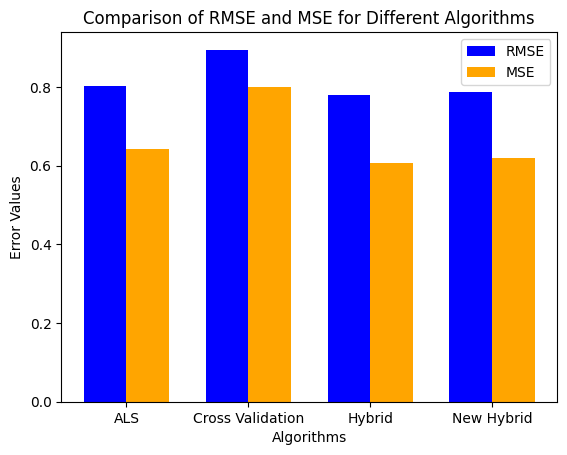

In [12]:
algorithms = ['ALS', 'Cross Validation', 'Hybrid', 'New Hybrid']
rmse_values = [als_rmse, cv_rmse, hybrid_rmse, new_hybrid_rmse]
mse_values = [als_mse, cv_mse, hybrid_mse, new_hybrid_mse]

bar_width = 0.35
index = np.arange(len(algorithms))

plt.bar(index, rmse_values, bar_width, label='RMSE', color='blue')
plt.bar(index + bar_width, mse_values, bar_width, label='MSE', color='orange')

plt.xlabel('Algorithms')
plt.ylabel('Error Values')
plt.title('Comparison of RMSE and MSE for Different Algorithms')
plt.xticks(index + bar_width / 2, algorithms)
plt.legend()
plt.show()